In [3]:
import pandas as pd

def load_fasttext_data(filepath):
    texts = []
    labels = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('__label__'):
                parts = line.split(' ', 1)
                label = parts[0].replace('__label__', '')
                text = parts[1]
                labels.append(label)
                texts.append(text)
    
    return pd.DataFrame({
        'review_text': texts,
        'sentiment': labels
    })

train_df = load_fasttext_data('C:/Users/91630/OneDrive/Desktop/nlp-sentiment-analysis/data/train.ft.txt')
test_df = load_fasttext_data('C:/Users/91630/OneDrive/Desktop/nlp-sentiment-analysis/data/test.ft.txt')

train_df.head()


,review_text,sentiment
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


In [4]:
train_df.shape
train_df['sentiment'].value_counts()


sentiment
2    1800000
1    1800000
Name: count, dtype: int64

In [5]:
train_df.shape

(3600000, 2)

In [6]:
# Rename sentiment for clarity
train_df['sentiment'] = train_df['sentiment'].astype(int)

# Separate classes
pos_df = train_df[train_df['sentiment'] == 2]
neg_df = train_df[train_df['sentiment'] == 1]

# Sample 50k from each
pos_sample = pos_df.sample(50000, random_state=42)
neg_sample = neg_df.sample(50000, random_state=42)

# Combine and shuffle
sample_df = pd.concat([pos_sample, neg_sample]).sample(frac=1, random_state=42)

sample_df.shape


(100000, 2)

In [7]:
sample_df['text_length'] = sample_df['review_text'].apply(len)

sample_df[['text_length']].describe()


,text_length
count,100000.000000
mean,431.601340
std,238.248247
min,101.000000
25%,231.000000
50%,382.000000
75%,595.000000
max,1015.000000


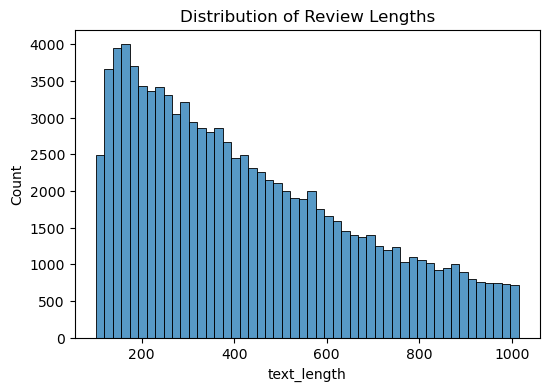

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.histplot(sample_df['text_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.show()


In [9]:
import re
import string

def clean_text(text):
    # lowercase
    text = text.lower()
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

sample_df['clean_text'] = sample_df['review_text'].apply(clean_text)

sample_df[['review_text', 'clean_text']].head()


,review_text,clean_text
1643026,East Side Kids: 10 Bowery classics: The video ...,east side kids bowery classics the video quali...
2752885,Hitting 4 month olds with a rod?!: This book p...,hitting month olds with a rod this book propos...
999551,Perfect!: We got this ice bucket just in time ...,perfect we got this ice bucket just in time fo...
384412,House of ZZZZZZZZZZZZZZZZZZ: Lindsay Crouse do...,house of zzzzzzzzzzzzzzzzzz lindsay crouse doe...
2224864,oh my gosh this was awful: One of my favorite ...,oh my gosh this was awful one of my favorite n...


In [10]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_stopwords(text):
    words = text.split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return ' '.join(words)

sample_df['clean_text'] = sample_df['clean_text'].apply(remove_stopwords)

sample_df[['clean_text']].head()


,clean_text
1643026,east kids bowery classics video quality poor d...
2752885,hitting month olds rod book proposes behaviors...
999551,perfect got ice bucket just time thanksgiving ...
384412,house zzzzzzzzzzzzzzzzzz lindsay crouse does h...
2224864,oh gosh awful favorite novels turned badly pro...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X = tfidf.fit_transform(sample_df['clean_text'])
y = sample_df['sentiment']

X.shape


(100000, 5000)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((80000, 5000), (20000, 5000))

In [13]:
from sklearn.linear_model import LogisticRegression

nlp_model = LogisticRegression(max_iter=1000)

nlp_model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [14]:
y_pred = nlp_model.predict(X_test)


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8773

Classification Report:

              precision    recall  f1-score   support

           1       0.88      0.87      0.88     10000
           2       0.87      0.88      0.88     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000


Confusion Matrix:

[[8740 1260]
 [1194 8806]]


In [16]:
feature_names = tfidf.get_feature_names_out()

In [17]:
import numpy as np
import pandas as pd

coefficients = nlp_model.coef_[0]

feature_importance = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})

# Sort by influence
top_positive = feature_importance.sort_values(by='coefficient', ascending=False).head(15)
top_negative = feature_importance.sort_values(by='coefficient', ascending=True).head(15)

top_positive, top_negative


(                  word  coefficient
 1924             great     9.515095
 1516         excellent     9.385141
 345               best     7.254732
 3196           perfect     6.722864
 246            awesome     6.697343
 119            amazing     6.369670
 4880         wonderful     5.882409
 2668              love     5.711046
 1596         fantastic     5.579202
 1616          favorite     5.185698
 1382              easy     4.841513
 3279           pleased     4.742457
 4904             works     4.718866
 2099  highly recommend     4.576373
 2080             helps     4.498733,
                 word  coefficient
 1219   disappointing   -10.332404
 4919           worst    -9.542867
 1216    disappointed    -9.291923
 1220  disappointment    -8.229553
 505           boring    -7.851568
 3304            poor    -7.615042
 2136        horrible    -7.468450
 4403        terrible    -7.251556
 4790           waste    -7.114494
 3306          poorly    -6.985741
 4645   unfortunately 